<div style="font-family: Impact; color: #832679ff; font-size: 30px;">
  GRUP-20:
</div>

<div style="
    font-family: 'Courier New', Courier, monospace; 
    background-color: #f4f6f7; 
    color: #2c3e50; 
    font-size: 25px; 
    font-weight: bold; 
    padding: 10px; 
    border-left: 6px solid #832679ff; 
    border-radius: 16px;">
  >> Sağlık ve Kaliteli Yaşam
<br>
<br>

<div style="
    font-family: 'Courier New', Courier, monospace; 
    color: #483446ff; 
    font-size: 20px; 
    line-height: 1.6;
    font-weight: 600;">
  Deniz Nizam - Endüstri Mühendisi <br>
  Özlem Limon - İngilizce Öğretmeni <br>
  Işıl Bengül Mantaroğlu - Kimya Mühendisliği Öğrencisi <br>
  Rabia Çelik - Bilgisayar Mühendisliği Öğrencisi
</div>

<div style="font-family: Impact; color: #832679ff; font-size: 30px; letter-spacing: 1px;">
  AMACIMIZ:
</div>

<div style="
    font-family: 'Segoe UI', sans-serif; 
    color: #4a235a; 
    font-size: 18px; 
    line-height: 1.5; 
    margin-top: 10px;">
  Karmaşık klinik verileri <b>görselleştirerek</b> analiz sürecini şeffaflaştırmak ve 
  geliştirdiğimiz deneysel <b>ML Chatbot</b> ile teşhis süreçlerinde interaktif, 
  veriye dayalı bir ön değerlendirme ortamı sunmak.
</div>
</div>

# **1) Kütüphanelerin ve Datasetin Yüklenmesi**

In [ ]:
import pandas as pd
import numpy as np
import oracledb
import warnings

warnings.filterwarnings('ignore')

# Makine Öğrenimi
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
4
print("\n1. Veri Oracle'dan Çekiliyor... ")

# 1. AYARLAR
# 1. AYARLAR
username = '******'      # Gizlendi
password = '******'      # Gizlendi
dsn = 'localhost:1521/orcl.home' # Adres
table_name = 'BREAST_CANCER_DATASET'

try:
    # Bağlantıyı aç ve veriyi çek
    connection = oracledb.connect(user=username, password=password, dsn=dsn)
    df = pd.read_sql(f"SELECT * FROM {table_name}", connection)
    connection.close()

    # --- KRİTİK DÜZELTME: Sütun İsimleri ---

    clean_columns = [
        'Age', 'Race', 'Marital Status',
        'T Stage ', 'N Stage', '6th Stage',
        'differentiate', 'Grade', 'A Stage',
        'Tumor Size', 'Estrogen Status', 'Progesterone Status',
        'Regional Node Examined',
        'Reginol Node Positive',
        'Survival Months', 'Status'
    ]

    if len(df.columns) == len(clean_columns):
        df.columns = clean_columns

    print("Veri hazırlandı!")

except Exception as e:
    print(f"HATA: {e}")
    # Eğer hata varsa kodu durdur ki boşuna aşağı inmesin
    raise


1. Veri Oracle'dan Çekiliyor... 
Veri hazırlandı!


# **2) Data Temizleme ve Önişleme**

In [2]:
print("\n 2.Veri Modelleniyor...")

# Modelin Girdileri (X): Sonucu (Evreyi) direkt veren sütunları çıkarıyoruz (T Stage, N Stage, 6th Stage vb.)
# Sadece "Ham" klinik verileri kullanacağız ki yapay zeka gerçekten tahmin etsin.
X = df[['Age', 'Race', 'Marital Status', 'Tumor Size',
        'Estrogen Status', 'Progesterone Status',
        'Regional Node Examined', 'Reginol Node Positive']]

# Hedef 1: Kanser Evresi (6th Stage)
y_stage = df['6th Stage']

# Hedef 2: Tümör Şiddeti/Karakteri (differentiate)
# Bu sütun tümörün "İyi Huyluya Yakın" (Well differentiated) mı yoksa
# "Agresif/Kötü" (Poorly differentiated) mi olduğunu söyler.
y_severity = df['differentiate']

# Kategorik Verileri Sayısallaştırma (Encoding)
le_encoders = {}
X_encoded = X.copy()

# Girdi değişkenlerini kodla
for col in X_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    le_encoders[col] = le

# Hedef değişkenleri kodla
le_stage = LabelEncoder()
y_stage_encoded = le_stage.fit_transform(y_stage)

le_severity = LabelEncoder()
y_severity_encoded = le_severity.fit_transform(y_severity)

# Veriyi Eğitim ve Test olarak ayır (%80 - %20)
X_train, X_test, y_stage_train, y_stage_test, y_sev_train, y_sev_test = train_test_split(
    X_encoded, y_stage_encoded, y_severity_encoded, test_size=0.2, random_state=42
)

# Ölçeklendirme (Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("-> Veriler hazırlandı. İki ayrı hedef için (Evre ve Şiddet) hazırlık tamam.")


 2.Veri Modelleniyor...
-> Veriler hazırlandı. İki ayrı hedef için (Evre ve Şiddet) hazırlık tamam.


# **3) GÖRSEL VERİ ANALİZİ (EDA)**


 3. Grafikler Çiziliyor...

Evrelerin Dağılımı:


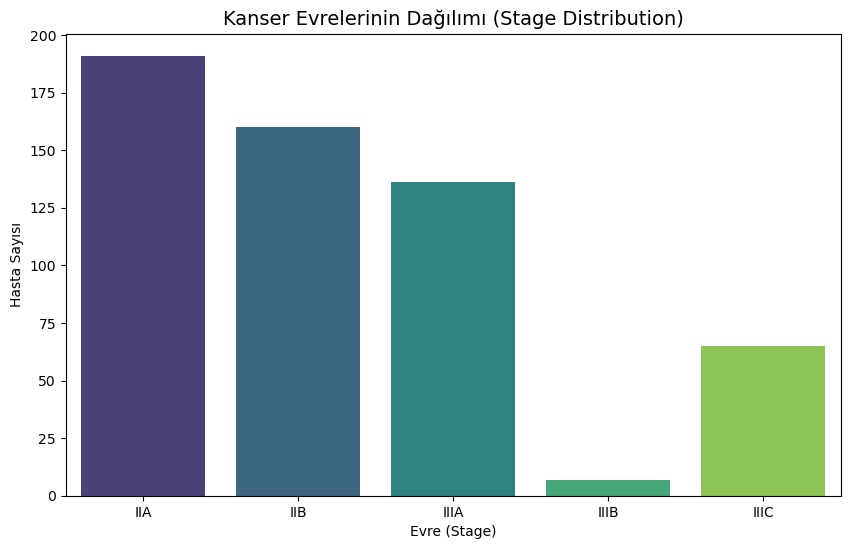

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n 3. Grafikler Çiziliyor...")

print("\nEvrelerin Dağılımı:")
# Grafik 1: Evrelerin Dağılımı
plt.figure(figsize=(10, 6))
sns.countplot(x=y_stage, palette='viridis', order=sorted(y_stage.unique()))
plt.title('Kanser Evrelerinin Dağılımı (Stage Distribution)', fontsize=14)
plt.xlabel('Evre (Stage)')
plt.ylabel('Hasta Sayısı')
plt.show()


Tümör Şiddeti (Farklılaşma) Dağılımı:


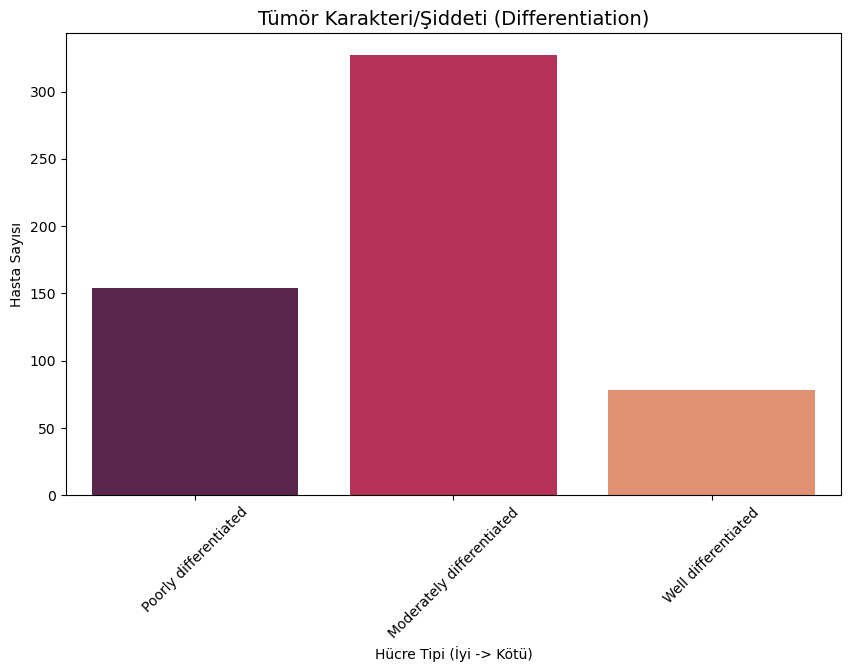

In [4]:
print("\nTümör Şiddeti (Farklılaşma) Dağılımı:")
# Grafik 2: Tümör Şiddeti (Farklılaşma) Dağılımı
plt.figure(figsize=(10, 6))
sns.countplot(x=y_severity, palette='rocket')
plt.title('Tümör Karakteri/Şiddeti (Differentiation)', fontsize=14)
plt.xlabel('Hücre Tipi (İyi -> Kötü)')
plt.ylabel('Hasta Sayısı')
plt.xticks(rotation=45)
plt.show()


Tümör Boyutu ve Evre İlişkisi:


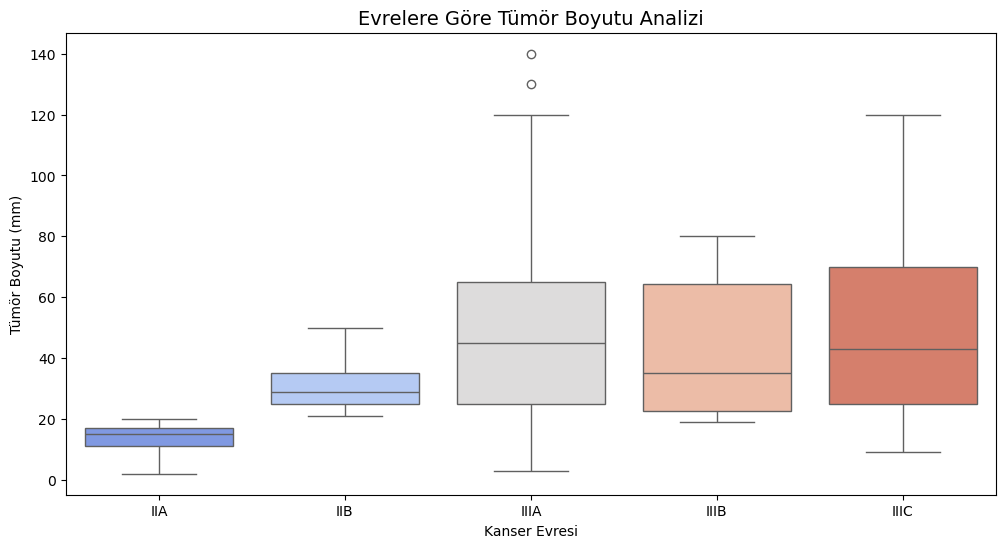

In [5]:
print("\nTümör Boyutu ve Evre İlişkisi:")
# Grafik 3: Tümör Boyutu ve Evre İlişkisi
# Evre arttıkça tümör boyutunun nasıl değiştiğini görelim
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='6th Stage', y='Tumor Size', palette='coolwarm', order=sorted(df['6th Stage'].unique()))
plt.title('Evrelere Göre Tümör Boyutu Analizi', fontsize=14)
plt.xlabel('Kanser Evresi')
plt.ylabel('Tümör Boyutu (mm)')
plt.show()


Tümör Boyutu ve Yaş İlişkisi:


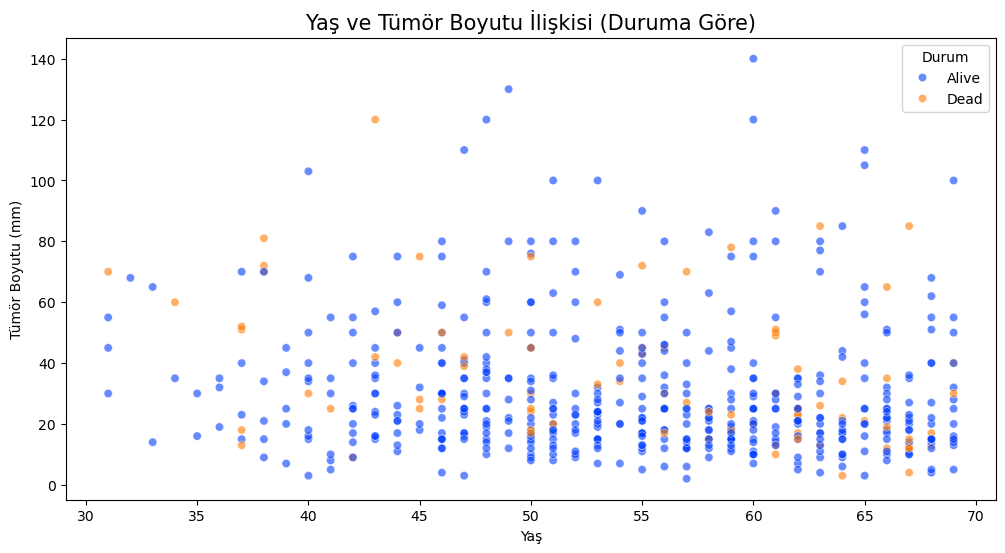

In [6]:
print("\nTümör Boyutu ve Yaş İlişkisi:")
# Grafik 4: Tümör Boyutu ve Yaş İlişkisi
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Age', y='Tumor Size', hue='Status', alpha=0.6, palette='bright')
plt.title('Yaş ve Tümör Boyutu İlişkisi (Duruma Göre)', fontsize=15)
plt.xlabel('Yaş')
plt.ylabel('Tümör Boyutu (mm)')
plt.legend(title='Durum')
plt.show()


Medeni Durum ve Irk Etkisi:


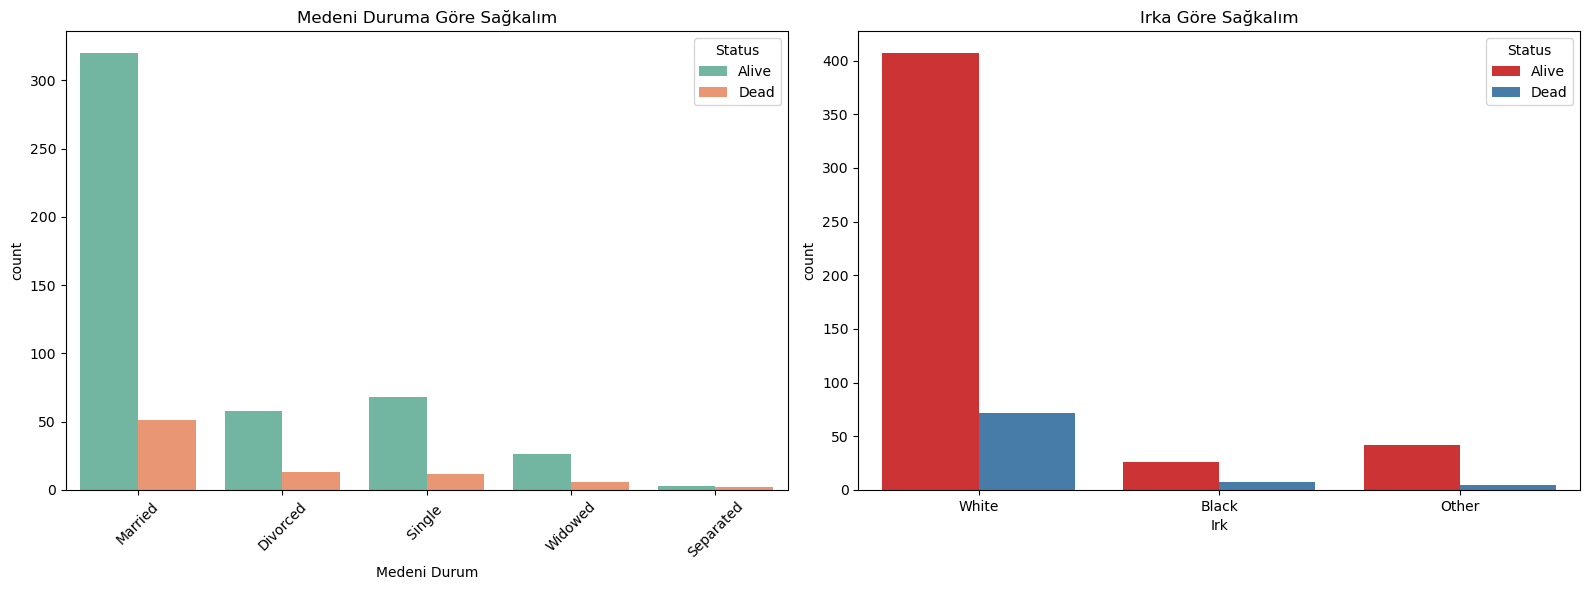

In [7]:
print("\nMedeni Durum ve Irk Etkisi:")
#Grafik 5: Medeni Durum ve Irk Etkisi
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(data=df, x='Marital Status', hue='Status', palette='Set2', ax=axes[0])
axes[0].set_title('Medeni Duruma Göre Sağkalım')
axes[0].set_xlabel('Medeni Durum')
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(data=df, x='Race', hue='Status', palette='Set1', ax=axes[1])
axes[1].set_title('Irka Göre Sağkalım')
axes[1].set_xlabel('Irk')
plt.tight_layout()
plt.show()

# **4) Yapay Zeka Modellerinin Eğitilmesi**

In [8]:
print("\n--- Yapay Zeka Modelleri Eğitiliyor ve Test Ediliyor ---")

# --- MODEL 1: Evre Tahminleyicisi (Stage Predictor) ---
rf_stage = RandomForestClassifier(n_estimators=150, random_state=42)
rf_stage.fit(X_train_scaled, y_stage_train)
y_pred_stage = rf_stage.predict(X_test_scaled)

# Skorlar
acc_stage = accuracy_score(y_stage_test, y_pred_stage)
f1_stage = f1_score(y_stage_test, y_pred_stage, average='weighted')

print(f"Evre Modeli Tamamlandı.")
print(f"Doğruluk (Accuracy): %{acc_stage*100:.2f}")
print(f"F1-Skoru (F1-Score): %{f1_stage*100:.2f}")
print("\n--- Evre Modeli Detaylı Rapor ---")
print(classification_report(y_stage_test, y_pred_stage, target_names=le_stage.classes_))

# --- MODEL 2: Tümör Karakteri Tahminleyicisi (Severity Predictor) ---
rf_severity = RandomForestClassifier(n_estimators=150, random_state=42)
rf_severity.fit(X_train_scaled, y_sev_train)
y_pred_sev = rf_severity.predict(X_test_scaled)

# Skorlar
acc_sev = accuracy_score(y_sev_test, y_pred_sev)
f1_sev = f1_score(y_sev_test, y_pred_sev, average='weighted')

print(f"\n Tümör Karakter Modeli Tamamlandı.")
print(f"Doğruluk (Accuracy): %{acc_sev*100:.2f}")
print(f"F1-Skoru (F1-Score): %{f1_sev*100:.2f}")
print("\n--- Tümör Karakter Modeli Detaylı Rapor ---")
print(classification_report(y_sev_test, y_pred_sev, target_names=le_severity.classes_))



--- Yapay Zeka Modelleri Eğitiliyor ve Test Ediliyor ---
Evre Modeli Tamamlandı.
Doğruluk (Accuracy): %93.75
F1-Skoru (F1-Score): %93.22

--- Evre Modeli Detaylı Rapor ---
              precision    recall  f1-score   support

         IIA       0.96      1.00      0.98        43
         IIB       0.94      0.97      0.95        31
        IIIA       0.88      0.92      0.90        24
        IIIB       0.00      0.00      0.00         1
        IIIC       1.00      0.77      0.87        13

    accuracy                           0.94       112
   macro avg       0.75      0.73      0.74       112
weighted avg       0.93      0.94      0.93       112


 Tümör Karakter Modeli Tamamlandı.
Doğruluk (Accuracy): %55.36
F1-Skoru (F1-Score): %50.24

--- Tümör Karakter Modeli Detaylı Rapor ---
                           precision    recall  f1-score   support

Moderately differentiated       0.61      0.83      0.70        63
    Poorly differentiated       0.45      0.30      0.36        33

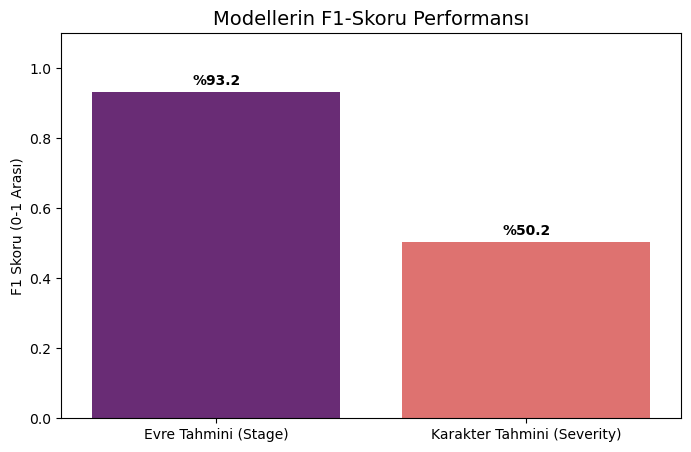

In [9]:
# Grafik: Başarı Karşılaştırması
plt.figure(figsize=(8, 5))
models = ['Evre Tahmini (Stage)', 'Karakter Tahmini (Severity)']
scores = [f1_stage, f1_sev]
sns.barplot(x=models, y=scores, palette='magma')
plt.title('Modellerin F1-Skoru Performansı', fontsize=14)
plt.ylabel('F1 Skoru (0-1 Arası)')
plt.ylim(0, 1.1)
for i, v in enumerate(scores):
    plt.text(i, v + 0.02, f"%{v*100:.1f}", ha='center', fontweight='bold')
plt.show()

# **5) Klinik Tanı Asistanı (AI CHATBOT)**

In [10]:


# KONTROL EDELİM
def kontrollu_input(soru, secenek_listesi=None):
   
    while True:
        try:
            deger = int(input(soru))
            
            # Eğer bu bir seçenek sorusuysa  kontrol et
            if secenek_listesi is not None:
                max_limit = len(secenek_listesi) - 1
                if 0 <= deger <= max_limit:
                    return deger # Doğruysa döngüden çık ve değeri ver
                else:
                    # HATA VARSA: Uyarı ver ve başa dön (while döngüsü sayesinde)
                    print(f"    HATA: Lütfen 0 ile {max_limit} arasında bir sayı seçiniz!")
            
            # Eğer sadece düz sayıysa
            else:
                if deger >= 0:
                    return deger
                else:
                    print("   HATA: Negatif sayı giremezsiniz!")
                    
        except ValueError:
            print("   HATA: Sadece sayı giriniz!")

# TABLOMUZU GÖSTERELİM

print("\n" + "="*50)
print("VERİ GİRİŞ REHBERİ (Kodlara buradan bakınız)")
print("="*50)

# Listeleri değişkene alalım ki aşağıda kontrolde kullanalım
list_race = le_encoders['Race'].classes_
list_mar = le_encoders['Marital Status'].classes_
list_est = le_encoders['Estrogen Status'].classes_
list_prog = le_encoders['Progesterone Status'].classes_

print(f"IRK KODLARI (0-{len(list_race)-1}):      {list(enumerate(list_race))}")
print(f"MEDENİ HAL (0-{len(list_mar)-1}):       {list(enumerate(list_mar))}")
print(f"ÖSTROJEN (0-{len(list_est)-1}):         {list(enumerate(list_est))}")
print(f"PROGESTERON (0-{len(list_prog)-1}):     {list(enumerate(list_prog))}")
print("-" * 50 + "\n")

#            VERİ GİRİŞİ 

print("HASTA BİLGİLERİNİ GİRİNİZ")

try:
    # Sayısal Veriler (Sadece negatif kontrolü yapar)
    yas = kontrollu_input("1. Yaş: ")
    boyut = kontrollu_input("2. Tümör Boyutu (mm): ")
    lenf_toplam = kontrollu_input("3. İncelenen Lenf Sayısı: ")
    lenf_pozitif = kontrollu_input("4. Pozitif Lenf Sayısı: ")

    # Kategorik Veriler (Listeye bakıp sınır kontrolü yapar)
    print("\n--- Seçmeli Kodlar (Yukarıdaki tabloya bakınız) ---")
    
    # Burada 2. parametre olarak listeyi gönderiyoruz, böylece sınırları biliyor
    irk = kontrollu_input("5. Irk Kodu: ", list_race)
    hal = kontrollu_input("6. Medeni Hal Kodu: ", list_mar)
    ost = kontrollu_input("7. Östrojen Kodu: ", list_est)
    prog = kontrollu_input("8. Progesteron Kodu: ", list_prog)

    #            HESAPLAMA
    
    veri = [[yas, irk, hal, boyut, ost, prog, lenf_toplam, lenf_pozitif]]
    
    try: veri_scaled = scaler.transform(np.array(veri))
    except: veri_scaled = np.array(veri)

    sonuc_evre = le_stage.inverse_transform(rf_stage.predict(veri_scaled))[0]
    sonuc_risk = le_severity.inverse_transform(rf_severity.predict(veri_scaled))[0]

    # Yorum
    if "III" in str(sonuc_evre):
        yorum = "RİSK: İleri evre bulgusu. Kapsamlı tedavi gerekir."
    elif "II" in str(sonuc_evre):
        yorum = "BİLGİ: Orta seviye. Standart tedavi uygulanır."
    else:
        yorum = "DURUM: Erken evre. Tedavi şansı yüksektir."

    # Yazdır
    print("\n" + "*"*40)
    print(" SONUÇ RAPORU")
    print("*"*40)
    print(f"Evre Tahmini:   {sonuc_evre}")
    print(f"Tümör Tipi:     {sonuc_risk}")
    print("-" * 40)
    print(f"Yorum: {yorum}")
    print("*"*40 + "\n")

except Exception as e:
    print(f"\nBeklenmedik Hata: {e}")


VERİ GİRİŞ REHBERİ (Kodlara buradan bakınız)
IRK KODLARI (0-2):      [(0, 'Black'), (1, 'Other'), (2, 'White')]
MEDENİ HAL (0-4):       [(0, 'Divorced'), (1, 'Married'), (2, 'Separated'), (3, 'Single '), (4, 'Widowed')]
ÖSTROJEN (0-1):         [(0, 'Negative'), (1, 'Positive')]
PROGESTERON (0-1):     [(0, 'Negative'), (1, 'Positive')]
--------------------------------------------------

HASTA BİLGİLERİNİ GİRİNİZ

--- Seçmeli Kodlar (Yukarıdaki tabloya bakınız) ---

****************************************
 SONUÇ RAPORU
****************************************
Evre Tahmini:   IIA
Tümör Tipi:     Moderately differentiated
----------------------------------------
Yorum: BİLGİ: Orta seviye. Standart tedavi uygulanır.
****************************************

